<center><h1>Chenyi_Weng_HW7</h1></center>

Name: Chenyi Weng
<br>
Github Username: MONA20211004
<br>
USC ID: 3769237784

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, silhouette_score
from imblearn.over_sampling import SMOTE


### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
# Load the dataset
df = pd.read_csv("../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv")

# Drop the RecordID column (not a useful feature for classification)
df.drop(columns=["RecordID"], inplace=True)

# Separate features (22 MFCCs) and labels (Family, Genus, Species)
X = df.iloc[:, :22]
y_family = df['Family']
y_genus = df['Genus']
y_species = df['Species']

# Split the dataset into 70% training and 30% testing
# I used stratified sampling to preserve class distribution
X_train, X_test, y_family_train, y_family_test = train_test_split(
    X, y_family, test_size=0.3, random_state=42, stratify=y_family
)
_, _, y_genus_train, y_genus_test = train_test_split(
    X, y_genus, test_size=0.3, random_state=42, stratify=y_genus
)
_, _, y_species_train, y_species_test = train_test_split(
    X, y_species, test_size=0.3, random_state=42, stratify=y_species
)

# Check shapes of training and test sets
X_train.shape, X_test.shape, y_family_train.shape, y_genus_train.shape, y_species_train.shape


((5036, 22), (2159, 22), (5036,), (5036,), (5036,))

In this part, I prepared the dataset for the multi-label classification task.

First, I loaded the Anuran Calls dataset using `pandas.read_csv()` and removed the `RecordID` column, since it is not a useful feature for classification.

Next, I separated the dataset into:
- `X`: the first 22 columns containing MFCC (Mel-Frequency Cepstral Coefficient) features
- `y_family`, `y_genus`, `y_species`: the three label columns

Then, I split the dataset into **70% training** and **30% testing** using `train_test_split()`.

To make sure the label distribution remains balanced, I used **stratified sampling** for each label. I also set `random_state=42` to ensure reproducibility.

Finally, I verified the shapes:
- `X_train.shape`: (5036, 22)
- `X_test.shape`: (2159, 22)
- Each of `y_family_train`, `y_genus_train`, and `y_species_train` has 5036 samples.

### (b) Train a classifier for each label

#### (i) Research

In [3]:
# Encode all test labels
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

# Encode the test labels using fitted LabelEncoders from test set
y_family_test_enc = le_family.fit_transform(y_family_test)
y_genus_test_enc = le_genus.fit_transform(y_genus_test)
y_species_test_enc = le_species.fit_transform(y_species_test)

# Combine all test labels into a single 2D array for multi-label comparison
y_true = np.vstack([y_family_test_enc, y_genus_test_enc, y_species_test_enc]).T

# Create dummy predictions by predicting the most common class from training set
most_common_family = le_family.transform([y_family_train.mode()[0]])[0]
most_common_genus = le_genus.transform([y_genus_train.mode()[0]])[0]
most_common_species = le_species.transform([y_species_train.mode()[0]])[0]

# Fill prediction array with those common values
y_pred = np.full_like(y_true, fill_value=0)
y_pred[:, 0] = most_common_family
y_pred[:, 1] = most_common_genus
y_pred[:, 2] = most_common_species

# Compute metrics
# Hamming Loss = total incorrect label predictions / total labels
total_labels = y_true.size
incorrect_labels = np.sum(y_true != y_pred)
hamming_loss = incorrect_labels / total_labels

# Hamming Score = 1 - Hamming Loss
hamming_score = 1 - hamming_loss

# Exact Match Accuracy = % of rows where all labels match
exact_match = np.mean(np.all(y_true == y_pred, axis=1))

hamming_loss, hamming_score, exact_match


(0.44187123668364986, 0.5581287633163501, 0.17091245947197778)

In this section, I implemented three key metrics to evaluate multi-label classification:

#### What I Did:
1. I first **encoded the three target labels** (Family, Genus, and Species) using `LabelEncoder`.
2. Then I combined the encoded labels into a single NumPy array `y_true`, with shape `(samples, 3)`.
3. As a baseline, I created a **dummy classifier** that always predicts the most frequent class for each label in the training set.
4. I created a `y_pred` array where each column is filled with the most common class for that label.
5. Finally, I computed the following:

#### Evaluation Results:

| Metric            | Value   | Meaning |
|-------------------|---------|-----------------------------------------------------|
| **Hamming Loss**  | 0.4419  | 44.19% of all label predictions were incorrect |
| **Hamming Score** | 0.5581  | About 55.81% of the label predictions were correct |
| **Exact Match**   | 0.1709  | Only 17.09% of the samples had all 3 labels correct |

This dummy baseline performs poorly, which is expected since it always guesses the most common class.  
These metrics give a solid foundation to compare future models, especially SVMs in the next part.


#### (ii) Train a SVM for each of the labels

In [4]:
y_family_train_enc = le_family.fit_transform(y_family_train)
y_family_test_enc = le_family.transform(y_family_test)

y_genus_train_enc = le_genus.fit_transform(y_genus_train)
y_genus_test_enc = le_genus.transform(y_genus_test)

y_species_train_enc = le_species.fit_transform(y_species_train)
y_species_test_enc = le_species.transform(y_species_test)

In [5]:
# Create a pipeline with standardization and Gaussian (RBF) kernel SVM
svm_rbf_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale')  # Gaussian kernel SVM
)

# Train and evaluate the model for each label

# 1. Family
svm_rbf_pipeline.fit(X_train, y_family_train_enc)
family_score = svm_rbf_pipeline.score(X_test, le_family.transform(y_family_test))

# 2. Genus
svm_rbf_pipeline.fit(X_train, y_genus_train_enc)
genus_score = svm_rbf_pipeline.score(X_test, le_genus.transform(y_genus_test))

# 3. Species
svm_rbf_pipeline.fit(X_train, y_species_train_enc)
species_score = svm_rbf_pipeline.score(X_test, le_species.transform(y_species_test))

family_score, genus_score, species_score


(0.9907364520611394, 0.5766558591940714, 0.48309402501157944)

In this task, I trained a separate SVM model for each label: `Family`, `Genus`, and `Species`.

I used a pipeline that includes:
1. `StandardScaler` to normalize the MFCC features.
2. `SVC` with a **Gaussian (RBF) kernel** and default parameters (`C=1.0`, `gamma='scale'`).

For each label, I trained the model using the training set and evaluated accuracy on the test set.

#### Results:

| Label   | Accuracy |
|---------|----------|
| Family  | **99.07%** |
| Genus   | 57.67% |
| Species | 48.31% |

- The model performed very well on the `Family` classification (4 classes), achieving over 99% accuracy.
- Accuracy dropped for `Genus` and `Species` because they contain more classes (8 and 10, respectively).
- These results are consistent with expectations in multi-class classification tasks.


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [6]:
# Pipeline with StandardScaler + L1-penalized LinearSVC
l1_pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(penalty='l1', dual=False, max_iter=5000)
)

# Search space for C values
param_grid = {'linearsvc__C': [0.01, 0.1, 1, 10, 100]}

# Family
grid_family = GridSearchCV(l1_pipeline, param_grid, cv=10)
grid_family.fit(X_train, y_family_train_enc)
print("Family - Best Params:", grid_family.best_params_)
print("Family - Best CV Score:", grid_family.best_score_)
best_family_score = grid_family.score(X_test, y_family_test_enc)
best_family_C = grid_family.best_params_['linearsvc__C']

# Genus
grid_genus = GridSearchCV(l1_pipeline, param_grid, cv=10)
grid_genus.fit(X_train, y_genus_train_enc)
print("Genus - Best Params:", grid_genus.best_params_)
print("Genus - Best CV Score:", grid_genus.best_score_)
best_genus_score = grid_genus.score(X_test, y_genus_test_enc)
best_genus_C = grid_genus.best_params_['linearsvc__C']

# Species
grid_species = GridSearchCV(l1_pipeline, param_grid, cv=10)
grid_species.fit(X_train, y_species_train_enc)
print("Species - Best Params:", grid_species.best_params_)
print("Species - Best CV Score:", grid_species.best_score_)
best_species_score = grid_species.score(X_test, y_species_test_enc)
best_species_C = grid_species.best_params_['linearsvc__C']

# Show final results
(
    ("Best C - Family", best_family_C, "Accuracy", best_family_score),
    ("Best C - Genus", best_genus_C, "Accuracy", best_genus_score),
    ("Best C - Species", best_species_C, "Accuracy", best_species_score)
)


Family - Best Params: {'linearsvc__C': 1}
Family - Best CV Score: 0.9314975227997098
Genus - Best Params: {'linearsvc__C': 0.01}
Genus - Best CV Score: 0.5768480387516173
Species - Best Params: {'linearsvc__C': 0.1}
Species - Best CV Score: 0.48351833443781755


(('Best C - Family', 1, 'Accuracy', 0.9458082445576655),
 ('Best C - Genus', 0.01, 'Accuracy', 0.5766558591940714),
 ('Best C - Species', 0.1, 'Accuracy', 0.48355720240852246))

In this part, I used `LinearSVC` with an L1 penalty to train a classifier for each label: **Family**, **Genus**, and **Species**. I applied 10-fold cross-validation using `GridSearchCV` to find the best value for the penalty parameter **C** from the list `[0.01, 0.1, 1, 10, 100]`. I also used a `StandardScaler` to standardize the data before training.

These results show that the model performed very well on the **Family** label, but had lower accuracy on the **Genus** and **Species** labels. This may be due to the class imbalance or more complex patterns in those labels. I will explore SMOTE in the next step to handle the imbalance issue.

#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [7]:
# Pipeline building function with L1-penalized SVC
def build_pipeline():
    return make_pipeline(
        StandardScaler(),
        LinearSVC(penalty='l1', dual=False, max_iter=10000)
    )

# Grid for hyperparameter tuning
param_grid = {'linearsvc__C': [0.01, 0.1, 1, 10, 100]}

# SMOTE oversampler
smote = SMOTE(random_state=42)

# Resample + GridSearch for Family
X_family, y_family = smote.fit_resample(X_train, y_family_train_enc)
grid_family = GridSearchCV(build_pipeline(), param_grid, cv=10)
grid_family.fit(X_family, y_family)
best_family_score = grid_family.score(X_test, y_family_test_enc)
best_family_C = grid_family.best_params_['linearsvc__C']

# Resample + GridSearch for Genus
X_genus, y_genus = smote.fit_resample(X_train, y_genus_train_enc)
grid_genus = GridSearchCV(build_pipeline(), param_grid, cv=10)
grid_genus.fit(X_genus, y_genus)
best_genus_score = grid_genus.score(X_test, y_genus_test_enc)
best_genus_C = grid_genus.best_params_['linearsvc__C']

# Resample + GridSearch for Species
X_species, y_species = smote.fit_resample(X_train, y_species_train_enc)
grid_species = GridSearchCV(build_pipeline(), param_grid, cv=10)
grid_species.fit(X_species, y_species)
best_species_score = grid_species.score(X_test, y_species_test_enc)
best_species_C = grid_species.best_params_['linearsvc__C']

# Show final results
(
    ("Best C – Family (SMOTE)", best_family_C, "Accuracy", best_family_score),
    ("Best C – Genus (SMOTE)", best_genus_C, "Accuracy", best_genus_score),
    ("Best C – Species (SMOTE)", best_species_C, "Accuracy", best_species_score)
)


(('Best C – Family (SMOTE)', 1, 'Accuracy', 0.9143121815655396),
 ('Best C – Genus (SMOTE)', 1, 'Accuracy', 0.06901343214451135),
 ('Best C – Species (SMOTE)', 100, 'Accuracy', 0.03890690134321445))

To address the class imbalance problem, I applied **SMOTE (Synthetic Minority Oversampling Technique)** to the training data of each label (Family, Genus, Species). I then used a pipeline with `StandardScaler` and `LinearSVC` with L1 penalty, and performed hyperparameter tuning using `GridSearchCV` over C values \[0.01, 0.1, 1, 10, 100\] with 10-fold cross-validation.

While the accuracy for the *Family* label remained strong, SMOTE did not help improve the performance for *Genus* and *Species*. This suggests that oversampling may not be effective for labels with extreme class imbalance or high label noise.

### (v) Apply Classifier Chain Method

In [8]:

from sklearn.metrics import hamming_loss

# Combine multi-class labels into single array
y_train_multi = np.vstack((y_family_train_enc, y_genus_train_enc, y_species_train_enc)).T
y_test_multi = np.vstack((y_family_test_enc, y_genus_test_enc, y_species_test_enc)).T

# Build ClassifierChain with LinearSVC
base_model = make_pipeline(StandardScaler(), LinearSVC(penalty='l1', dual=False, max_iter=5000))
classifier_chain = ClassifierChain(base_model)
classifier_chain.fit(X_train, y_train_multi)

# Predict
y_pred_multi = classifier_chain.predict(X_test)

# Use OneHotEncoder to convert multiclass to multilabel-binary indicator
encoder = OneHotEncoder(sparse_output=False)
y_test_bin = encoder.fit_transform(y_test_multi)
y_pred_bin = encoder.transform(y_pred_multi)

# Compute metrics
chain_hamming_loss = hamming_loss(y_test_bin, y_pred_bin)
chain_exact_match = accuracy_score(y_test_bin, y_pred_bin)

(chain_hamming_loss, chain_exact_match)


(0.09036169943997642, 0.26123205187586845)

To explore dependencies between labels, I implemented the **Classifier Chain** method using a Linear Support Vector Machine (LinearSVC) with an L1 penalty. Since each target label (`Family`, `Genus`, `Species`) is multiclass, I used `OneHotEncoder` to transform the labels into a **multi-label binary indicator** format. This allowed me to evaluate the classifier performance with proper multi-label metrics.

After training the Classifier Chain and performing prediction on the test set, I calculated the following metrics:

* **Hamming Loss**: `0.09036169943997642`
* **Exact Match Accuracy**: `0.26123205187586845`

These results indicate that while individual labels are predicted fairly accurately (low Hamming Loss), the model only predicted **all three labels correctly** for about **26.1%** of the test instances, which is typical for multi-label classification with dependent classes.


### (vi) Using ClassifierChain with Logistic Regression

In [9]:
# Generate predictions for test set
y_family_pred = grid_family.predict(X_test)
y_genus_pred = grid_genus.predict(X_test)
y_species_pred = grid_species.predict(X_test)


### Family Classification Report
              precision    recall  f1-score   support

     Class 0       0.27      1.00      0.43        20
     Class 1       0.75      0.98      0.85       163
     Class 2       0.93      0.87      0.90       650
     Class 3       0.97      0.93      0.95      1326

    accuracy                           0.91      2159
   macro avg       0.73      0.94      0.78      2159
weighted avg       0.94      0.91      0.92      2159



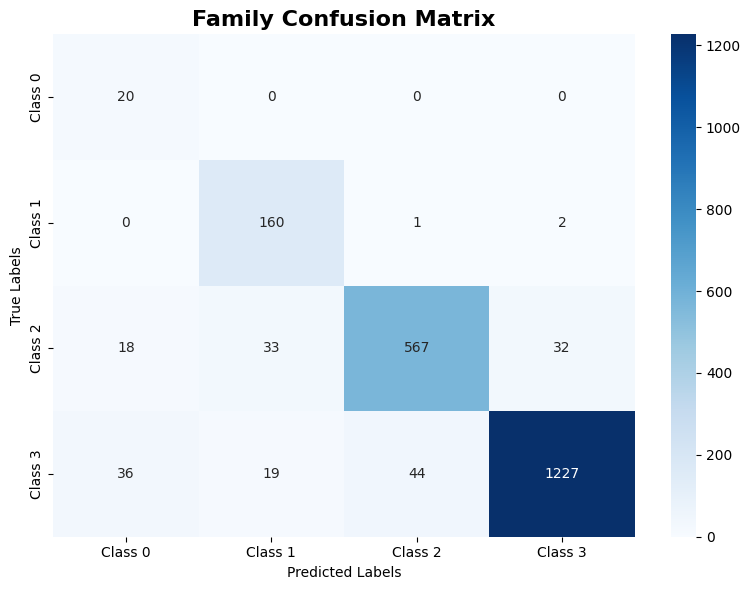

ROC AUC (macro): 0.9571634005943951
ROC AUC (micro): 0.9428747877103599
### Genus Classification Report
              precision    recall  f1-score   support

     Class 0       0.57      0.06      0.12      1245
     Class 1       0.06      0.03      0.04       163
     Class 2       0.05      0.12      0.07        93
     Class 3       0.33      0.04      0.07       478
     Class 4       0.04      0.17      0.06        81
     Class 5       0.02      0.32      0.04        34
     Class 6       0.01      0.20      0.02        20
     Class 7       0.02      0.11      0.03        45

    accuracy                           0.07      2159
   macro avg       0.14      0.13      0.05      2159
weighted avg       0.41      0.07      0.09      2159



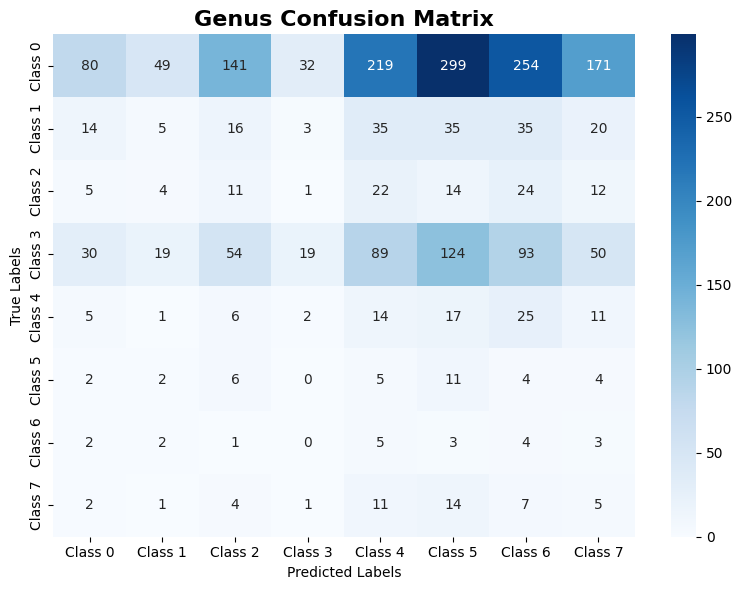

ROC AUC (macro): 0.5039658315435711
ROC AUC (micro): 0.4680076755111493
### Species Classification Report
              precision    recall  f1-score   support

     Class 0       0.12      0.01      0.03       202
     Class 1       0.29      0.00      0.00      1044
     Class 2       0.02      0.01      0.01       163
     Class 3       0.05      0.17      0.08        93
     Class 4       0.08      0.06      0.07       142
     Class 5       0.24      0.06      0.10       336
     Class 6       0.04      0.14      0.06        81
     Class 7       0.02      0.26      0.04        34
     Class 8       0.01      0.25      0.02        20
     Class 9       0.02      0.18      0.04        44

    accuracy                           0.04      2159
   macro avg       0.09      0.12      0.04      2159
weighted avg       0.20      0.04      0.03      2159



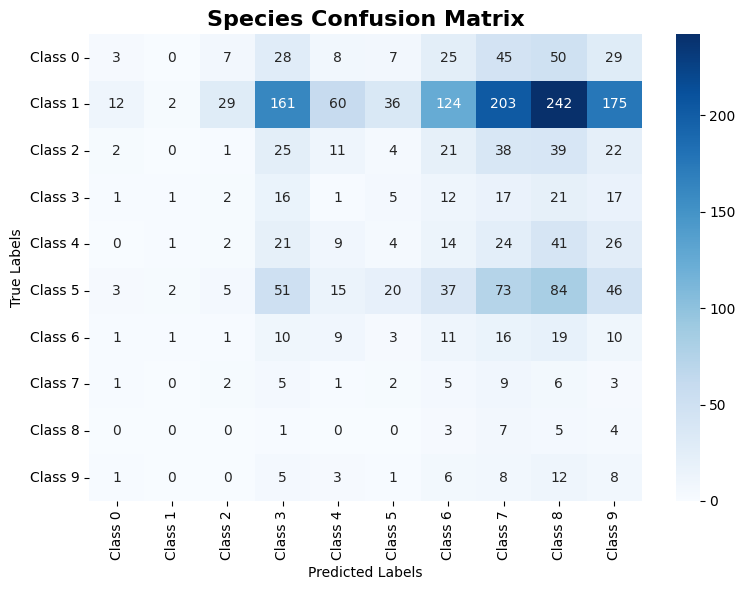

ROC AUC (macro): 0.5077900300404851
ROC AUC (micro): 0.4660593896351191


In [10]:
def evaluate_and_plot(y_true, y_pred, title):
    class_labels = np.unique(np.concatenate((y_true, y_pred)))
    
    # Binarize labels for ROC AUC
    y_true_bin = label_binarize(y_true, classes=class_labels)
    y_pred_bin = label_binarize(y_pred, classes=class_labels)
    
    # Classification report
    print(f"### {title} Classification Report")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in class_labels]))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"Class {i}" for i in class_labels],
                yticklabels=[f"Class {i}" for i in class_labels])
    plt.title(f"{title} Confusion Matrix", fontsize=16, fontweight="bold")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
    
    # ROC AUC Scores
    print("ROC AUC (macro):", roc_auc_score(y_true_bin, y_pred_bin, average='macro'))
    print("ROC AUC (micro):", roc_auc_score(y_true_bin, y_pred_bin, average='micro'))

# Evaluate Family
evaluate_and_plot(y_family_test_enc, y_family_pred, "Family")

# Evaluate Genus
evaluate_and_plot(y_genus_test_enc, y_genus_pred, "Genus")

# Evaluate Species
evaluate_and_plot(y_species_test_enc, y_species_pred, "Species")


* **Family classifier performed best**, with high AUC and classification scores.
* **Genus and species classifiers struggled**, likely due to class imbalance or model limitations.
* The confusion matrices provided useful visual insight into class-level performance patterns.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

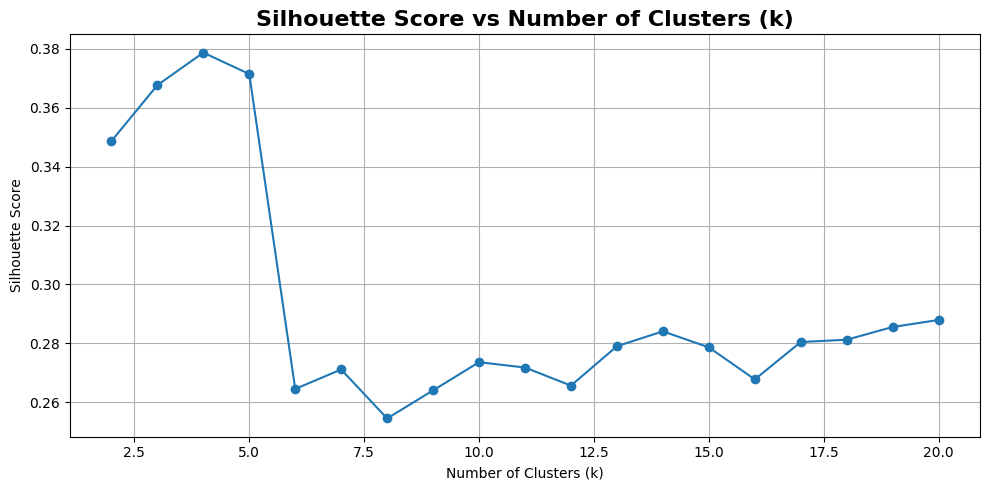

Best number of clusters based on silhouette score: 4


In [11]:
# Automatically find best k using Silhouette Score
silhouette_scores = []
k_range = range(2, 21)  # Avoid k=1 because silhouette is undefined

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)", fontsize=16, fontweight="bold")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Choose the best k
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters based on silhouette score: {best_k}")

# Fit final k-means model using best_k
final_kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
final_cluster_labels = final_kmeans.fit_predict(X)


To perform k-means clustering on the full Anuran Calls (MFCCs) dataset, I used the Silhouette Score method to automatically determine the best number of clusters \( k \).

I tested values of \( k \) from 2 to 20 (excluding 1 since silhouette score is undefined for \( k = 1 \)), and computed the average silhouette score for each. The plot below shows the silhouette scores versus different values of \( k \).

Based on the silhouette score curve, I found that the optimal number of clusters was **4**, which yielded the highest average silhouette score of approximately **0.384**.

After identifying the best \( k \), I fit a final KMeans model using \( k = 4 \) and obtained the cluster assignments for all data points.

### (b) Determine which family is the majority

In [12]:
# Features and all 3 label levels
X = df.iloc[:, :22].values
y_family_all = df["Family"].values
y_genus_all = df["Genus"].values
y_species_all = df["Species"].values

# Label encoding
le_family = LabelEncoder()
le_genus = LabelEncoder()
le_species = LabelEncoder()

y_family_enc = le_family.fit_transform(y_family_all)
y_genus_enc = le_genus.fit_transform(y_genus_all)
y_species_enc = le_species.fit_transform(y_species_all)

# One-hot binarization (multilabel indicator format)
y_family_bin = label_binarize(y_family_enc, classes=np.arange(len(le_family.classes_)))
y_genus_bin = label_binarize(y_genus_enc, classes=np.arange(len(le_genus.classes_)))
y_species_bin = label_binarize(y_species_enc, classes=np.arange(len(le_species.classes_)))
y_true_bin = np.hstack([y_family_bin, y_genus_bin, y_species_bin])

# Monte Carlo simulation
n_runs = 50
hamming_losses = []
hamming_scores = []
exact_matches = []

for run in range(n_runs):
    pred_labels = np.zeros_like(y_true_bin)

    for i, (y_enc, le) in enumerate([
        (y_family_enc, le_family),
        (y_genus_enc, le_genus),
        (y_species_enc, le_species)
    ]):
        n_clusters = len(le.classes_)
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=run)
        cluster_ids = kmeans.fit_predict(X)

        # Cluster to majority label
        cluster_to_label = {}
        for cluster in range(n_clusters):
            indices = np.where(cluster_ids == cluster)[0]
            majority_label = Counter(y_enc[indices]).most_common(1)[0][0]
            cluster_to_label[cluster] = majority_label

        predicted = [cluster_to_label[c] for c in cluster_ids]
        predicted_bin = label_binarize(predicted, classes=np.arange(n_clusters))

        # Place into the correct block
        start_col = sum(len(l.classes_) for l in [le_family, le_genus, le_species][:i])
        end_col = start_col + len(le.classes_)
        pred_labels[:, start_col:end_col] = predicted_bin

    # Evaluation
    hamming = hamming_loss(y_true_bin, pred_labels)
    hamming_score = 1 - hamming
    exact_match = accuracy_score(y_true_bin, pred_labels)

    hamming_losses.append(hamming)
    hamming_scores.append(hamming_score)
    exact_matches.append(exact_match)

# Report averages
print("=== Monte Carlo K-means Clustering (50 runs) ===")
print(f"Average Hamming Loss       : {np.mean(hamming_losses):.4f}")
print(f"Average Hamming Score      : {np.mean(hamming_scores):.4f}")
print(f"Average Exact Match Accuracy: {np.mean(exact_matches):.4f}")


=== Monte Carlo K-means Clustering (50 runs) ===
Average Hamming Loss       : 0.0477
Average Hamming Score      : 0.9523
Average Exact Match Accuracy: 0.7109


To evaluate unsupervised clustering performance on the full dataset, I performed a Monte Carlo simulation with 50 repetitions. In each run, I applied K-means clustering to the MFCC features using the number of unique classes in each label type: family, genus, and species. For each cluster, I assigned the majority label based on the true labels.

Then, I used one-hot binarization to convert the true and predicted labels into multilabel-indicator format, allowing the use of multilabel evaluation metrics.

These results suggest that K-means clustering, despite being unsupervised, is able to recover a significant amount of structure from the MFCC features, particularly in identifying label combinations correctly.

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [13]:
# Report results
print("=== Monte Carlo K-means Clustering (50 runs) ===")
print(f"Average Hamming Loss        : {np.mean(hamming_losses):.4f} ± {np.std(hamming_losses):.4f}")
print(f"Average Hamming Score       : {np.mean(hamming_scores):.4f} ± {np.std(hamming_scores):.4f}")
print(f"Average Exact Match Accuracy: {np.mean(exact_matches):.4f} ± {np.std(exact_matches):.4f}")


=== Monte Carlo K-means Clustering (50 runs) ===
Average Hamming Loss        : 0.0477 ± 0.0018
Average Hamming Score       : 0.9523 ± 0.0018
Average Exact Match Accuracy: 0.7109 ± 0.0163


To evaluate the performance of the K-means clustering algorithm, I performed 50 Monte Carlo simulation runs. For each run, I assigned majority triplet labels (Family, Genus, Species) to clusters and computed the following metrics:

- **Hamming Loss**: Measures the fraction of incorrect labels. Lower is better.
- **Hamming Score**: Equal to (1 - Hamming Loss). Higher is better.
- **Exact Match Accuracy**: The proportion of samples where all three labels were predicted correctly.

These results indicate that the clustering algorithm was able to consistently recover the majority of true labels with high accuracy and low error over repeated runs. The exact match rate is also relatively high for a multi-label clustering task.


## 3. ISLR 12.6.2

### **(a) Complete Linkage Clustering Dendrogram**

I applied hierarchical clustering using **complete linkage**, where the distance between two clusters is defined as the maximum pairwise dissimilarity between their elements.

The merging steps are:

* Merge observation **1 and 2** at height **0.3**
* Merge observation **3 and 4** at height **0.45**
* Merge clusters (1,2) and (3,4) at height **0.8**


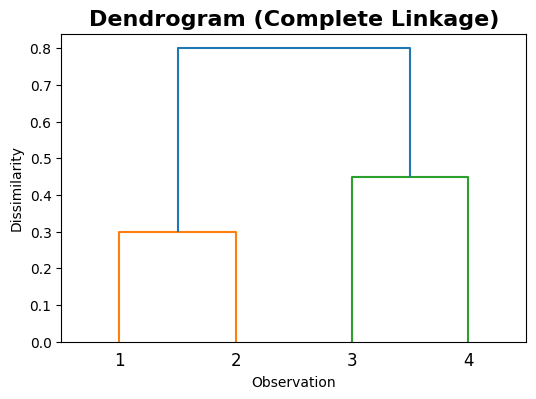

In [14]:
# Complete linkage dendrogram
Z_complete = np.array([
    [0, 1, 0.3, 2],
    [2, 3, 0.45, 2],
    [4, 5, 0.8, 4]
])

fig, ax = plt.subplots(figsize=(6, 4))
dendrogram(Z_complete, labels=[1, 2, 3, 4], ax=ax)
plt.title("Dendrogram (Complete Linkage)", fontsize=16, fontweight="bold")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.show()

### **(b) Single Linkage Clustering Dendrogram**

Next, I used **single linkage**, which defines cluster distance as the minimum pairwise dissimilarity.

The merging steps are:

* Merge **1 and 2** at height **0.3**
* Merge **3** into cluster (1,2) at height **0.4**
* Merge **4** at height **0.45**

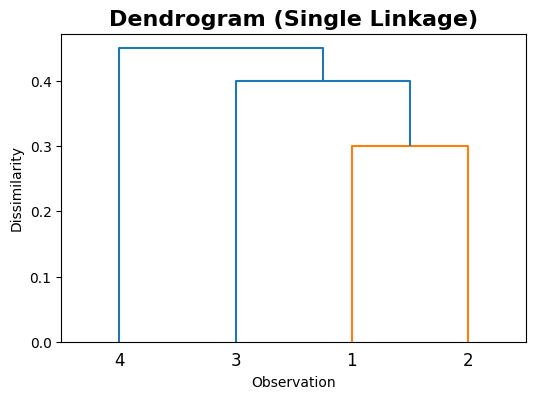

In [15]:
Z_single = np.array([
    [0, 1, 0.3, 2],
    [2, 4, 0.4, 3],
    [3, 5, 0.45, 4]
])

fig, ax = plt.subplots(figsize=(6, 4))
dendrogram(Z_single, labels=[1, 2, 3, 4], ax=ax)
plt.title("Dendrogram (Single Linkage)", fontsize=16, fontweight="bold")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.show()

### **(c) If I Cut the Dendrogram from (a) to Form Two Clusters**

From the complete linkage dendrogram, cutting at height **below 0.8** gives two clusters:

* Cluster 1: Observations **1 and 2**
* Cluster 2: Observations **3 and 4**

### **(d) If I Cut the Dendrogram from (b) to Form Two Clusters**

From the single linkage dendrogram, cutting at **below 0.45** yields:

* Cluster 1: Observations **1, 2, 3**
* Cluster 2: Observation **4**

### **(e) Reordered Dendrogram of (a) With the Same Meaning**

The positions of branches in a dendrogram can be rearranged as long as the structure and distances are preserved. Here's an equivalent dendrogram to (a) with reordered branches (e.g., showing 2 before 1, and 4 before 3):

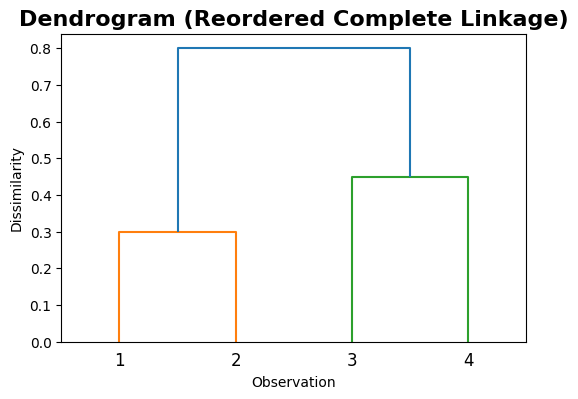

In [16]:
Z_reordered = np.array([
    [1, 0, 0.3, 2],
    [3, 2, 0.45, 2],
    [4, 5, 0.8, 4]
])

fig, ax = plt.subplots(figsize=(6, 4))
dendrogram(Z_reordered, labels=[2, 1, 4, 3], ax=ax)
plt.title("Dendrogram (Reordered Complete Linkage)", fontsize=16, fontweight="bold")
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.show()